In [1]:
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister, Aer, execute
from qiskit.circuit.library.basis_change.qft import QFT
import numpy as np
import matplotlib.pyplot as plt
from svinspector import StatevectorInspector
from quantum_mlp import *

## Unit tests

In [2]:
def set_register(circuit, register, value):
    bits = to_binary(value, register.size).nonzero()[0]
    for bit in bits:
        circuit.x(register[bit])

In [3]:
def get_vector_and_probs(circuit):
    statevector_simulator = Aer.get_backend('statevector_simulator')
    statevector_simulator.set_options(method='statevector_gpu')
    data = execute(circuit, statevector_simulator).result().data()['statevector']
    data = data.reshape(tuple(2 ** reg.size for reg in reversed(circuit.qregs)))
    data.real = np.where(np.abs(data.real) > 1.e-8, data.real, 0.)
    data.imag = np.where(np.abs(data.imag) > 1.e-8, data.imag, 0.)
    probs = np.square(np.abs(data))
    
    return data, probs

In [4]:
def print_prob_table(probs):
    for idx in sorted(probs):
        print(' '.join(str(k) for k in idx) + ':', probs[idx])

### Data loading

10 qubits


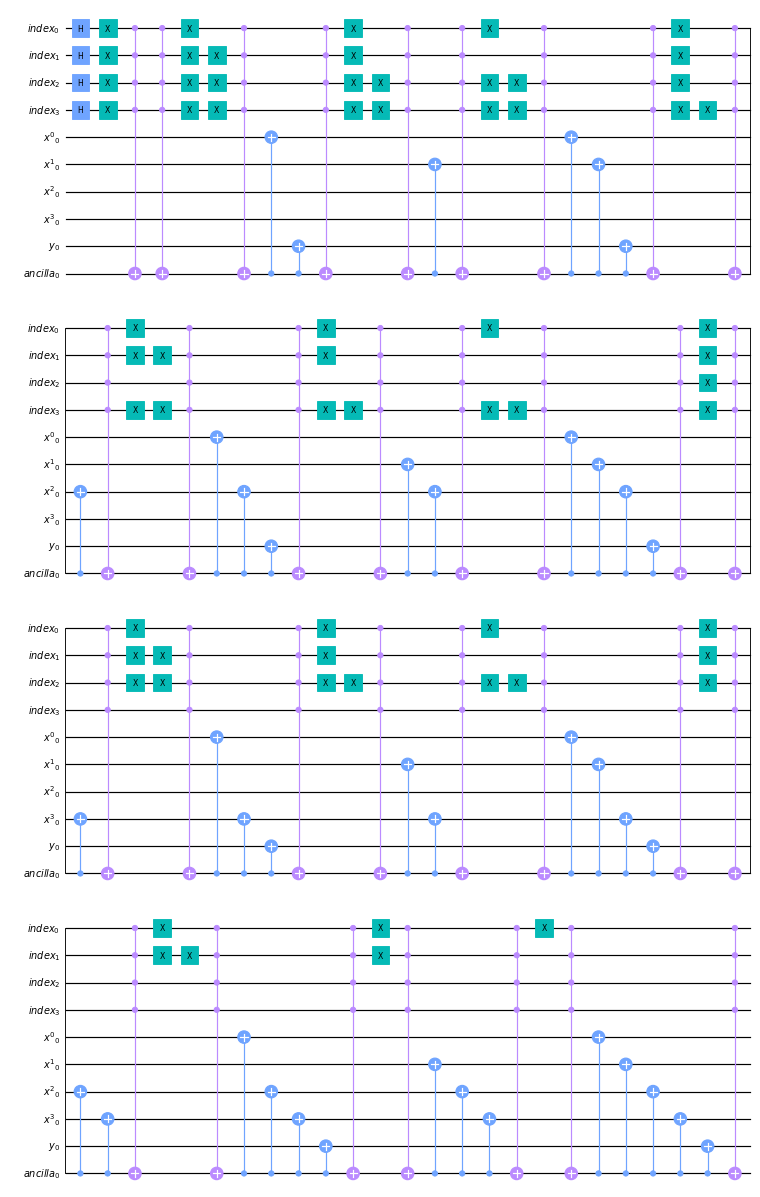

In [5]:
log2_num_samples = 4
x_dim = 4
x_precision = 1
reg_index = QuantumRegister(log2_num_samples, 'index')
reg_x = list(QuantumRegister(x_precision, 'x^{{{}}}'.format(i)) for i in range(x_dim))
reg_y = QuantumRegister(1, 'y')
# using to_binary because x_precision is 1
x = to_binary(np.arange(2 ** log2_num_samples), log2_num_samples)
y = np.tile(np.array([0, 1]), 2 ** (log2_num_samples - 1))

data_loading_circuit = load_data(reg_index, reg_x, reg_y[0], x, y, gatify=0)
print(data_loading_circuit.num_qubits, 'qubits')
data_loading_circuit.draw('mpl', scale=0.6)

In [6]:
data, probs = get_vector_and_probs(data_loading_circuit)

svi = StatevectorInspector(data, data_loading_circuit.qregs)
regs, nonzero_probs = svi.get_probs(sum_over=['ancilla'], nonzero_only=True)
print(regs)
print_prob_table(nonzero_probs)

ndim = len(data_loading_circuit.qregs)
print('Ancilla is clean:', np.sum(probs, axis=tuple(range(1, ndim))))
print('Probability per index:', np.sum(probs, axis=tuple(range(ndim - 1))))
print('Nonzero indices:', np.stack(data[0].nonzero()).T)

['y', 'x^{3}', 'x^{2}', 'x^{1}', 'x^{0}', 'index']
0 0 0 0 0 0: 0.06250000000000003
0 0 0 1 0 2: 0.06250000000000003
0 0 1 0 0 4: 0.06250000000000003
0 0 1 1 0 6: 0.0625
0 1 0 0 0 8: 0.06250000000000003
0 1 0 1 0 10: 0.0625
0 1 1 0 0 12: 0.0625
0 1 1 1 0 14: 0.06249999999999997
1 0 0 0 1 1: 0.06250000000000003
1 0 0 1 1 3: 0.0625
1 0 1 0 1 5: 0.0625
1 0 1 1 1 7: 0.06249999999999997
1 1 0 0 1 9: 0.0625
1 1 0 1 1 11: 0.06249999999999997
1 1 1 0 1 13: 0.06249999999999997
1 1 1 1 1 15: 0.06249999999999996
Ancilla is clean: [1. 0.]
Probability per index: [0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]
Nonzero indices: [[ 0  0  0  0  0  0]
 [ 0  0  0  1  0  2]
 [ 0  0  1  0  0  4]
 [ 0  0  1  1  0  6]
 [ 0  1  0  0  0  8]
 [ 0  1  0  1  0 10]
 [ 0  1  1  0  0 12]
 [ 0  1  1  1  0 14]
 [ 1  0  0  0  1  1]
 [ 1  0  0  1  1  3]
 [ 1  0  1  0  1  5]
 [ 1  0  1  1  1  7]
 [ 1  1  0  0  1  9]
 [ 1  1  0  1  1 11]
 [ 1  1  1  0  1 1

### Data propagation

#### Single bit

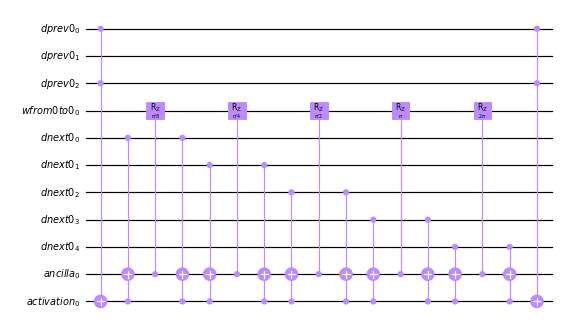

In [7]:
prev_layer_num_nodes = 3
prev_layer_d_width = 2
next_layer_num_nodes = 2
next_layer_d_width = prev_layer_d_width + np.ceil(np.log2(prev_layer_num_nodes))

layer_input = list(QuantumRegister(prev_layer_d_width + 1, 'dprev{}'.format(i)) for i in range(prev_layer_num_nodes))
layer_weights = list(list(QuantumRegister(1, 'wfrom{}to{}'.format(iprev, inext)) for iprev in range(prev_layer_num_nodes)) for inext in range(next_layer_num_nodes))
layer_biases = list(QuantumRegister(next_layer_d_width + 1, 'bias{}'.format(i)) for i in range(next_layer_num_nodes))
layer_output = list(QuantumRegister(next_layer_d_width + 1, 'dnext{}'.format(i)) for i in range(next_layer_num_nodes))

single_accum_circuit = add_weighted_input_single(layer_input[0][0], layer_weights[0][0][0], layer_output[0], layer_input[0][-1], gatify=0)
single_accum_circuit.draw('mpl', scale=0.6)

In [8]:
test_circuit = QuantumCircuit(*single_accum_circuit.qregs)
# x = -1, w = 1 -> o = sum_{k} |k> (relu activation: no propagation)
set_register(test_circuit, layer_input[0], 7)
set_register(test_circuit, layer_weights[0][0], 1)

test_circuit.h(layer_output[0])
# accummulate_phase applies an X to the sign bit
test_circuit.x(layer_input[0][-1])
test_circuit += single_accum_circuit
test_circuit.x(layer_input[0][-1])

data, probs = get_vector_and_probs(test_circuit)

ndim = len(single_accum_circuit.qregs)
print('Ancilla is clean:', np.sum(probs, axis=tuple(range(2, ndim))))
probs_noanc = probs[0, 0]
data_noanc = data[0, 0]
ndim -= 1
print('No change to input:', np.sum(probs_noanc, axis=0))
data_output = data_noanc[data_noanc.nonzero()]
print('Output phase:', np.log(data_output).imag / np.pi)

Ancilla is clean: [[1. 0.]
 [0. 0.]]
No change to input: [[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
Output phase: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [9]:
test_circuit = QuantumCircuit(*single_accum_circuit.qregs)
# x = 1, w = 0 -> o = sum_{k} exp(2*pi*i/16 * (-1) * k) |k>
set_register(test_circuit, layer_input[0], 1)

test_circuit.h(layer_output[0])
# accummulate_phase applies an X to the sign bit
test_circuit.x(layer_input[0][-1])
test_circuit += single_accum_circuit
test_circuit.x(layer_input[0][-1])

data, probs = get_vector_and_probs(test_circuit)

ndim = len(single_accum_circuit.qregs)
print('Ancilla is clean:', np.sum(probs, axis=tuple(range(2, ndim))))
probs_noanc = probs[0, 0]
data_noanc = data[0, 0]
print('No change to input:', np.sum(probs_noanc, axis=0))
data_output = data_noanc[data_noanc.nonzero()]
print('Output phase:', np.log(data_output).imag / np.pi)

Ancilla is clean: [[1. 0.]
 [0. 0.]]
No change to input: [[0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
Output phase: [ 0.     -0.0625 -0.125  -0.1875 -0.25   -0.3125 -0.375  -0.4375 -0.5
 -0.5625 -0.625  -0.6875 -0.75   -0.8125 -0.875  -0.9375  1.      0.9375
  0.875   0.8125  0.75    0.6875  0.625   0.5625  0.5     0.4375  0.375
  0.3125  0.25    0.1875  0.125   0.0625]


#### Single output node

24 qubits


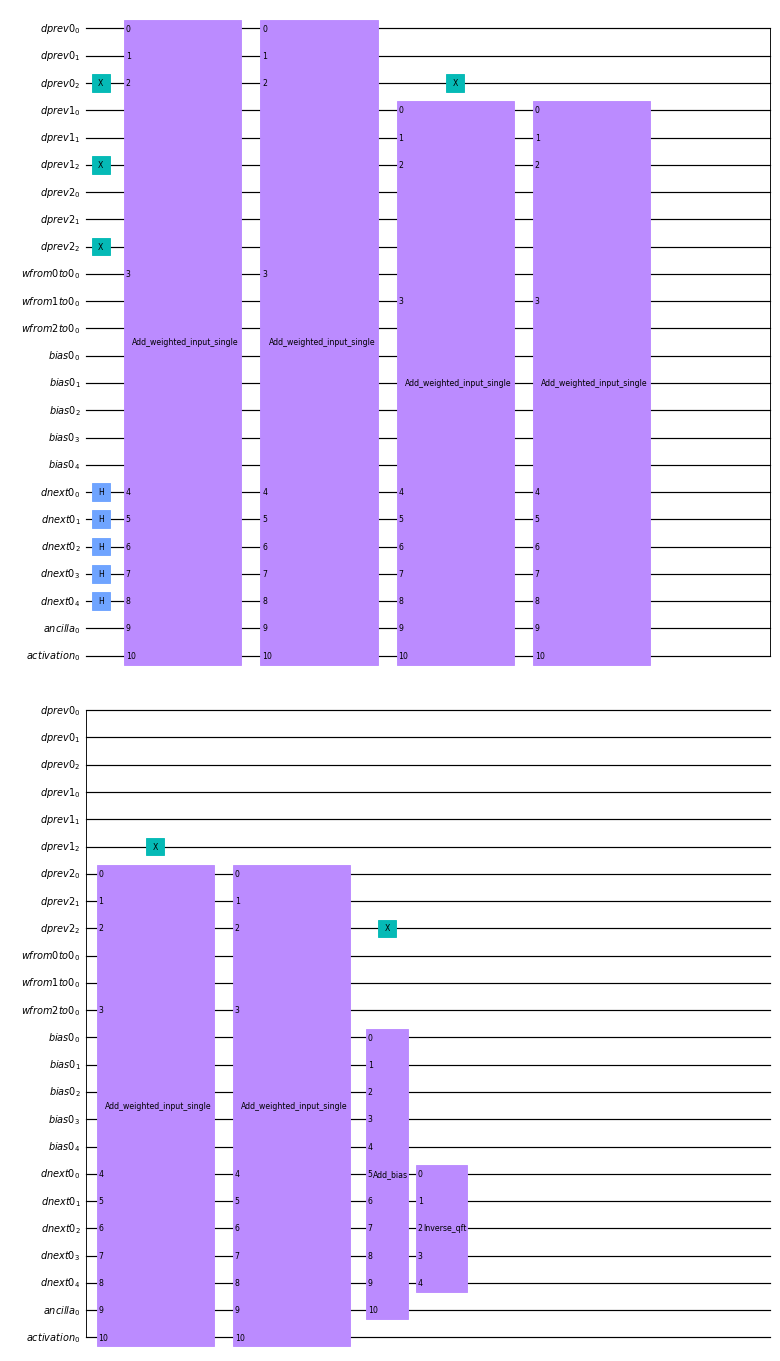

In [10]:
single_propagation_circuit = propagate_one(layer_input, layer_weights[0], layer_biases[0], layer_output[0], True, gatify=1)
print(single_propagation_circuit.num_qubits, 'qubits')
single_propagation_circuit.draw('mpl', scale=0.6)

In [11]:
test_circuit = QuantumCircuit(*single_propagation_circuit.qregs)
# x_0 = -1, x_1 = 2, x_2 = 3; w_0 = -1, w_1 = 1, w_2 = -1, b = 2 -> o = |1>
set_register(test_circuit, layer_input[0], 7)
set_register(test_circuit, layer_input[1], 2)
set_register(test_circuit, layer_input[2], 3)
set_register(test_circuit, layer_weights[0][1], 1)
set_register(test_circuit, layer_biases[0], 2)

test_circuit += single_propagation_circuit

data, probs = get_vector_and_probs(test_circuit)

ndim = len(single_propagation_circuit.qregs)
print('Ancilla is clean:', np.sum(probs, axis=tuple(range(2, ndim))))
probs_noanc = probs[0, 0]
data_noanc = data[0, 0]
nonzero_elem = np.flip(np.squeeze(np.stack(np.sum(probs_noanc, axis=0).nonzero())))
print('No change to input:', nonzero_elem)
print('Output:', data_noanc.nonzero()[0])

Ancilla is clean: [[1. 0.]
 [0. 0.]]
No change to input: [7 2 3 0 1 0 2]
Output: [1]


#### Layer output

28 qubits


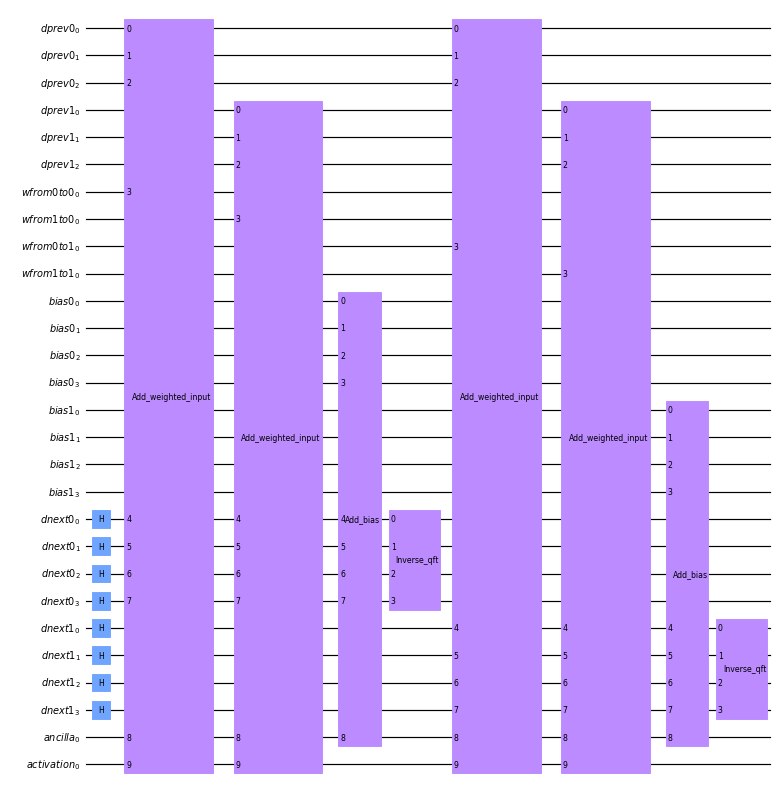

In [12]:
prev_layer_num_nodes = 2
prev_layer_d_width = 2
next_layer_num_nodes = 2
next_layer_d_width = prev_layer_d_width + np.ceil(np.log2(prev_layer_num_nodes))

layer_input = list(QuantumRegister(prev_layer_d_width + 1, 'dprev{}'.format(i)) for i in range(prev_layer_num_nodes))
layer_weights = list(list(QuantumRegister(1, 'wfrom{}to{}'.format(iprev, inext)) for iprev in range(prev_layer_num_nodes)) for inext in range(next_layer_num_nodes))
layer_biases = list(QuantumRegister(next_layer_d_width + 1, 'bias{}'.format(i)) for i in range(next_layer_num_nodes))
layer_output = list(QuantumRegister(next_layer_d_width + 1, 'dnext{}'.format(i)) for i in range(next_layer_num_nodes))

propagation_circuit = propagate(layer_input, layer_weights, layer_biases, layer_output, True, gatify=2)
print(propagation_circuit.num_qubits, 'qubits')
propagation_circuit.draw('mpl', scale=0.6)

In [13]:
test_circuit = QuantumCircuit(*propagation_circuit.qregs)
# x_0 = -1, x_1 = 2
# w^0_0 = -1, w^0_1 = 1
# w^1_0 = 1, w^1_1 = -1
# b^0 = 4, b^1 = -3
#-> o = |6>|-5>
set_register(test_circuit, layer_input[0], 7)
set_register(test_circuit, layer_input[1], 2)
set_register(test_circuit, layer_weights[0][1], 1)
set_register(test_circuit, layer_weights[1][0], 1)
set_register(test_circuit, layer_biases[0], 4)
set_register(test_circuit, layer_biases[1], 12)

test_circuit += propagation_circuit

data, probs = get_vector_and_probs(test_circuit)

ndim = len(propagation_circuit.qregs)
print('Ancilla is clean:', np.sum(probs, axis=tuple(range(2, ndim))))
probs_noanc = probs[0, 0]
data_noanc = data[0, 0]
nonzero_elem = np.flip(np.squeeze(np.stack(np.sum(probs_noanc, axis=(0, 1)).nonzero())))
print('No change to input:', nonzero_elem)
nonzero_elems = data_noanc.nonzero()
print('Output:', nonzero_elems[1], nonzero_elems[0])

Ancilla is clean: [[1. 0.]
 [0. 0.]]
No change to input: [ 7  2  0  1  1  0  4 12]
Output: [6] [8]


#### Network output

28 qubits


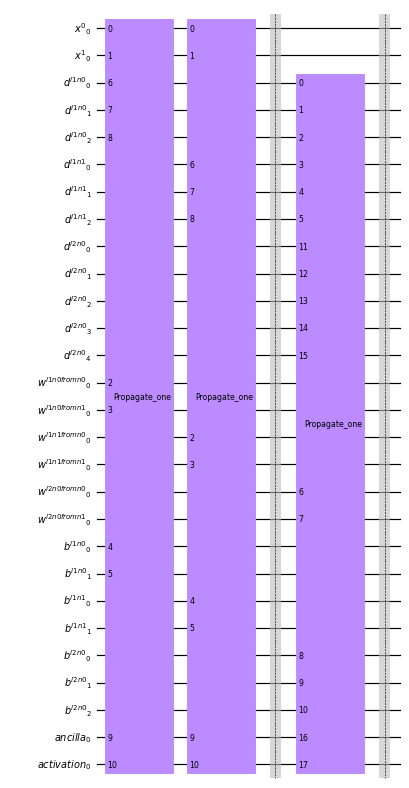

In [14]:
layer_nodes = [2, 2]
input_x = to_binary(np.arange(4), 2)
input_y = np.array([1, 0, 0, 1])

reg_input_index, reg_data_input_y, reg_data, reg_weights, reg_biases, reg_amp = setup_registers(layer_nodes, input_x, input_y, 1)

feedforward_circuit = feedforward(reg_data, reg_weights, reg_biases, gatify=4)
print(feedforward_circuit.num_qubits, 'qubits')
feedforward_circuit.draw('mpl', scale=0.6)

In [15]:
test_circuit = QuantumCircuit(*feedforward_circuit.qregs)
# x_0 = 0, x_1 = 1
# w(to_l1_n0_from_l0_n0) = -1, w(to_l1_n0_from_l0_n1) = 1
# w(to_l1_n1_from_l0_n0) = 1, w(to_l1_n1_from_l0_n1) = -1
# w(to_l2_n0_from_l1_n0) = -1, w(to_l2_n0_from_l1_n1) = 1
# b(l1_n0) = 1, b(l1_n1) = -1
# b(l2_n0) = -3
#-> o = -7
set_register(test_circuit, reg_data[0][1], 1)
set_register(test_circuit, reg_weights[0][0][1], 1)
set_register(test_circuit, reg_weights[0][1][0], 1)
set_register(test_circuit, reg_weights[1][0][1], 1)
set_register(test_circuit, reg_biases[0][0], 1)
set_register(test_circuit, reg_biases[0][1], 3)
set_register(test_circuit, reg_biases[1][0], 7)

test_circuit += feedforward_circuit

data, probs = get_vector_and_probs(test_circuit)

svi = StatevectorInspector(data, feedforward_circuit.qregs)
regs, probs = svi.get_probs(sum_over=['ancilla', 'activation'], nonzero_only=True)
print(regs)
print_prob_table(probs)

['b^{l2n0}', 'b^{l1n1}', 'b^{l1n0}', 'w^{l2n0fromn1}', 'w^{l2n0fromn0}', 'w^{l1n1fromn1}', 'w^{l1n1fromn0}', 'w^{l1n0fromn1}', 'w^{l1n0fromn0}', 'd^{l2n0}', 'd^{l1n1}', 'd^{l1n0}', 'x^{1}', 'x^{0}']
7 3 1 1 0 0 1 1 0 28 6 2 1 0: 0.9999999999999998


In [ ]:
test_circuit = QuantumCircuit(*feedforward_circuit.qregs)
# x_0 = 1, x_1 = 1
# w(to_l1_n0_from_l0_n0) = 1, w(to_l1_n0_from_l0_n1) = 1
# w(to_l1_n1_from_l0_n0) = -1, w(to_l1_n1_from_l0_n1) = -1
# w(to_l2_n0_from_l1_n0) = 1, w(to_l2_n0_from_l1_n1) = -1
# b(l1_n0) = 2, b(l1_n1) = -1
# b(l2_n0) = -4
#-> o = 2
set_register(test_circuit, reg_data[0][0], 1)
set_register(test_circuit, reg_data[0][1], 1)
set_register(test_circuit, reg_weights[0][0][0], 1)
set_register(test_circuit, reg_weights[0][0][1], 1)
set_register(test_circuit, reg_weights[1][0][0], 1)
set_register(test_circuit, reg_biases[0][0], 2)
set_register(test_circuit, reg_biases[0][1], 7)
set_register(test_circuit, reg_biases[1][0], 8)

test_circuit += feedforward_circuit

data, probs = get_vector_and_probs(test_circuit)

svi = StatevectorInspector(data, feedforward_circuit.qregs)
regs, probs = svi.get_probs(sum_over=['ancilla', 'activation'], nonzero_only=True)
print(regs)
print_prob_table(probs)

In [ ]:
test_circuit = QuantumCircuit(*feedforward_circuit.qregs)
# full superposition
for reg in reg_data[0]:
    test_circuit.h(reg)
for reg in flatten_list(reg_weights):
    test_circuit.h(reg)

test_circuit += feedforward_circuit

data, probs = get_vector_and_probs(test_circuit)

svi = StatevectorInspector(data, feedforward_circuit.qregs)
regs, probs = svi.get_probs(sum_over=['ancilla', 'activation'], nonzero_only=True)
print(regs)
for idx, _ in probs.items():
    l1n0 = idx[10] * (1 if idx[5] == 1 else -1) + idx[9] * (1 if idx[4] == 1 else -1)
    l1n1 = idx[10] * (1 if idx[3] == 1 else -1) + idx[9] * (1 if idx[2] == 1 else -1)
    if (l1n0 + 8) % 8 != idx[8] or (l1n1 + 8) % 8 != idx[7]:
        print('Layer 1 calculation mismatch:', idx, 'l1n1={} l1n0={}'.format((l1n1 + 8) % 8, (l1n0 + 8) % 8))
        
    l1n0 = max(0, l1n0)
    l1n1 = max(0, l1n1)
        
    l2n0 = l1n0 * (1 if idx[1] == 1 else -1) + l1n1 * (1 if idx[0] == 1 else -1)
    if (l2n0 + 16) % 16 != idx[6]:
        print('Layer 2 calculation mismatch:', idx, 'l2n0={}'.format((l2n0 + 16) % 16))

### Amplitude transduction

In [ ]:
reg_y = QuantumRegister(1, 'y')
out_node_data = QuantumRegister(4, 'output')
reg_amp = QuantumRegister(1, 'amp')

transduction_circuit = transduce_amplitude(reg_y[0], out_node_data, reg_amp[0], gatify=0)
transduction_circuit.draw('mpl', scale=1)

In [ ]:
test_circuit = QuantumCircuit(*transduction_circuit.qregs)
# y = 1, output = 6 -> amp = cos(pi/4 * (1 - 6/8))
set_register(test_circuit, reg_y, 1)
set_register(test_circuit, out_node_data, 6)

test_circuit += transduction_circuit

data, probs = get_vector_and_probs(test_circuit)

amp_probs = np.sum(probs, axis=(1, 2))
print('Probs:', amp_probs)
theta = np.arccos(np.sqrt(amp_probs[0])) / np.pi * 4.
print('Theta:', theta, '* pi/4')

In [ ]:
test_circuit = QuantumCircuit(*transduction_circuit.qregs)
# y = 1, output = -5 -> amp = cos(pi/4 * (1 + 5/8))
set_register(test_circuit, reg_y, 1)
set_register(test_circuit, out_node_data, 11)

test_circuit += transduction_circuit

data, probs = get_vector_and_probs(test_circuit)

amp_probs = np.sum(probs, axis=(1, 2))
print('Probs:', amp_probs)
theta = np.arccos(np.sqrt(amp_probs[0])) / np.pi * 4.
print('Theta:', theta, '* pi/4')

### Smallest possible circuit

In [ ]:
layer_nodes = [1]
input_x = to_binary(np.arange(2), 1)
input_y = np.array([1, 0])
test_circuit = binary_mlp(layer_nodes, input_x, input_y)

print(test_circuit.num_qubits, 'qubits')
test_circuit.draw('mpl', scale=0.6)

In [ ]:
data, probs = get_vector_and_probs(test_circuit)
svi = StatevectorInspector(data, test_circuit.qregs)
print(svi.get_subsystem(subsystem={'ancilla': 0, 'activation': 0}))
#regs, probs = svi.get_probs(sum_over=['ancilla', 'activation'], nonzero_only=True)